In [3]:
pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [transformers] [transformers]ub]
Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import random
import os


### SEED 고정

In [67]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [68]:
# 데이터 로드
save_path = "../"

train_df = pd.read_csv(save_path + 'data/train_preprocseeing_0210_2.csv')
train_df['synthetic'] = 'no'

test_df = pd.read_csv(save_path + 'data/test_preprocseeing_0210_3.csv')
submission_df = pd.read_csv(save_path + 'data/submission.csv')

## Augmentation

In [69]:
aug_rt_df = pd.read_csv(save_path + 'data/aug_rt_preprocseeing.csv')
aug_rt_df['synthetic'] = 'back translation en'
train_df = pd.concat([train_df, aug_rt_df], axis=0)

In [70]:
train_df

,class,conversation,synthetic
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,no
1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,no
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,no
3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,no
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,no
...,...,...,...
3620,기타 괴롭힘 대화,"왜 자꾸 때리나요? 내가 뭘 잘못했나요? 아니, 아무 문제도 없는데 왜? 당신을 볼...",back translation en
3621,기타 괴롭힘 대화,준하야 머리가 왜 이렇게 커? 내 머리에 무슨 문제가 있습니까? 밥을 먹으면 머리가...,back translation en
3622,갈취 대화,나는 지금 당신의 아들 김길준을 데리고 가고 있습니다. 저장하고 싶으시면 계좌로 1...,back translation en
3623,직장 내 괴롭힘 대화,선생님 같은 분들을 보면 정말 신기해요. 어떻게 그렇게 살 수 있죠? 무슨 일이야?...,back translation en


## 일반대화 합성 데이터 셋

In [71]:
general_k_p_df = pd.read_csv(save_path + 'data/general_k_p_preprocseeing.csv') # keywords with persona
general_k_p_df['synthetic'] = 'keyword with persona'
general_c_k_df = pd.read_csv(save_path + 'data/general_k_preprocseeing.csv') # importance keywords
general_c_k_df = general_c_k_df.sample(n=1500, random_state=seed)
general_c_k_df['synthetic'] = 'keyword'
train_df = pd.concat([train_df, general_k_p_df, general_c_k_df], axis=0)

In [72]:
train_df.loc[train_df['class'] == '협박 대화', 'class'] = 0
train_df.loc[train_df['class'] == '갈취 대화', 'class'] = 1
train_df.loc[train_df['class'] == '직장 내 괴롭힘 대화', 'class'] = 2
train_df.loc[train_df['class'] == '기타 괴롭힘 대화', 'class'] = 3
train_df.loc[train_df['class'] == '일반 대화', 'class'] = 4

In [73]:
pd.set_option('display.unicode.east_asian_width', True)
print("[Class Distribution]")
print(train_df['class'].value_counts())

print("=" * 100)

# 데이터 예시
display(train_df.head(5))

[Class Distribution]
class
4    2801
3    1962
2    1894
1    1886
0    1728
Name: count, dtype: int64


,class,conversation,synthetic
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,no
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,no
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,no
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,no
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,no


## 사전 학습된 모델 불러오기

In [74]:
# roberta
#from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification


#bert_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)
#tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

# KR-ELECTRA
from transformers import ElectraModel, ElectraTokenizer, ElectraForSequenceClassification

kr_electra_model = ElectraForSequenceClassification.from_pretrained("snunlp/KR-ELECTRA-discriminator", num_labels=5)
tokenizer = ElectraTokenizer.from_pretrained("snunlp/KR-ELECTRA-discriminator")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: klue/bert-base
Key                                        | Status     | 
-------------------------------------------+------------+-
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on you

## Dataloader

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


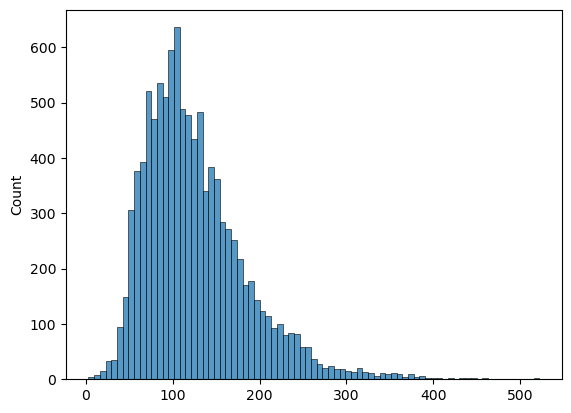

log value : 246.11699640284087


In [75]:
import seaborn as sns

tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train_df['conversation']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+2*np.std(tokenizer_len)}')

In [45]:
a = 'none'
len(a)

4

In [76]:

class CleanTalkDataset(Dataset):
    def __init__(self, data, labels, is_trainable, synthetic_type, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.data = []
        self.labels = labels
        self.trainable = is_trainable
        self.synthetic_type = synthetic_type

        self.data = [tokenizer(text, padding='max_length', max_length=250, truncation=True, add_special_tokens=True, return_tensors='pt') for text in data.values]
       

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        
        if len(self.synthetic_type) == len(self.data):
            syn_type = self.synthetic_type.values[idx]

        else:
            syn_type = torch.tensor([-1])
    
        if self.trainable:
            target = torch.tensor(self.labels.values[idx])
            return (sample, syn_type), target

        else: 
            return (sample,syn_type), torch.tensor([-1])

In [77]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_val = train_test_split(train_df, test_size = 0.2, shuffle = True, random_state = 42, stratify=train_df['class'])

train_dataset = CleanTalkDataset(dataset_train['conversation'],dataset_train['class'],True,  dataset_train['synthetic'],tokenizer)
val_dataset = CleanTalkDataset(dataset_val['conversation'], dataset_val['class'], True, dataset_val['synthetic'], tokenizer)

for (text,syn_type), label in train_dataset:

    print(text)
    print(label)
    print(syn_type)

    break

{'input_ids': tensor([[    2,  3686,  2170,  2259,  4610,  2121,  2218,  2157,  2069, 21372,
          2275,  1889,  2118,  1380,  2075,  2182,    35,  1439,    18,  3994,
          1041,  2052, 18556,  2182,    18,  4292,   732,  2116,  1041,  2205,
          2259,  3611,  2073,  6697,  2181,  1502,    35,    35,    35,  1556,
          3649,  2203,  2182,    18,  5036,  3616,  2116,  1892,  1295,  1513,
          2259,  1507,  2073,  6321,  2119,  1415,  2219,  3606,    18,  3686,
          2170,  8675,  2069,  8106,  1380,  6076,  1545,  2125,  2496,  2259,
           568,  7562,  2321,    35,  7822, 11800,    18,  1535,  2170,  2318,
          1891,  1141,  2154,  4118,  2138,  1564, 14924,    18,  3616,  4226,
          2259,  4230,  5032,  2062,    18,  3656,  3826,  2052,  1513,  2075,
          2182,    35, 15338,    18,  3982,  2052,  5027,  2470,  3826, 12190,
            18,  4061,  2138, 11287,  2275,  3657,  2182,    35, 27325,  2170,
          5884,  2205,  2259,   647,  

In [57]:
#dataset_train.to_csv(save_path + 'data/k_p_aug_tr_trainset.csv',index=False)
#dataset_val.to_csv(save_path + 'data/k_p_aug_tr_valset.csv',index=False)
dataset_val

,class,conversation,synthetic
919,4,"안녕하세요, 친구. 어제는 정말 힘들었어요? 네, 저도 많이 힘들었습니다. 우리 학...",keyword with persona
1693,2,자내는 문턱세라고 들어봤는가? 문턱세요? 아니 이렇게 시험에 붙어서 공무원이 됐으면...,no
2323,2,이대리 이거 빨리해줘 저 . 이 일이 급해서 이것부터 하구요 빨리해달라고 회의 들어...,no
509,1,야 김계란 매점가냐? 으. 응 야 내껀 초코우유랑 소시지빵 사와라. 도. 돈은? 야...,no
1240,4,"아빠, 오늘 학교에서 우리가 배운 역학을 해볼까? 네, 그럼 어떤 역을 고르면 좋겠...",keyword with persona
...,...,...,...
2265,2,야 목살 주문 받지말고 목살 품절 됐어 그리고 김매니저한테도 얘기해줘 넵 알겠습니다...,no
2117,3,얘 결혼 축하해! 고마워. 와줬구나. 당연하지 우리 동창생 중에 니가 제일 빨리 가...,no
466,3,너가 내 여자친구 좋아한다고 했냐? 와 저런 오타쿠가 그랬다고? 꼴값이다 진짜. 내...,no
2144,1,"이봐, 돈 좀 줘 저는 학생입니다. 나는 돈이 없습니다. 무슨 말이 되나요? 지갑을...",back translation en


In [78]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=False)

for (text,syn_type), label in train_dataloader:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())
    print(label.size())
    break

torch.Size([64, 1, 250])
torch.Size([64, 1, 250])
torch.Size([64])


## 모델 학습

In [79]:
from tqdm import tqdm
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

def model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patiece, model_nm):
    best_acc = 0
    early_stopping_threshold_count = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)  # cuda 또는 cpu 출력
    model.to(device)

    # class weight
    #numSample_list = [1000, 1000,1000,1000,5000]
    #class_weights = [1 - (x / sum(numSample_list)) for x in numSample_list]
    #class_weights = torch.FloatTensor(class_weights).to(device)
    
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss(class_weights)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    t_total = len(train_dataloader) * epochs
    #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * 0.1), num_training_steps=t_total)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * 0.1), num_training_steps=t_total)
    
    model = model.to(device)
    
    total_acc_train = []
    total_loss_train = []
    total_acc_val = []
    total_loss_val = []
    
    for epoch in range(epochs):
        
        train_loss_=0.0
        total = 0.0
        correct = 0.0
        
        model.train() # sets into the training mode
        
        for (train_input, syn_type), label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].squeeze(1).to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            label = label.to(device)

            optimizer.zero_grad()
            
            output = model(input_ids, attention_mask) # from the forward function
            #print(output[0])
            loss = criterion(output.logits, label) 
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss_ += loss.item()

            preds = output[0].argmax(dim=-1)
            correct += (preds == label).sum().item()
            #correct += calc_accuracy(output[0], label)
            total += label.size(0)
            
        total_loss_train.append(train_loss_ / len(train_dataloader))
        total_acc_train.append(correct / total)
        
        print(f'Epochs: {epoch + 1} '
              f'| Train Loss: {total_loss_train[-1] : .3f} '
              f'| Train Accuracy: {total_acc_train[-1] : .3f} ')

        with torch.no_grad(): # since we should not change gradient for validation 

            val_loss = 0.0
            val_total = 0.0
            val_correct = 0.0
            
            model.eval() # deactivate training
            
            # same process as the above
            for (val_input, syn_type), label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].squeeze(1).to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                label = label.to(device)
                
                output = model(input_ids, attention_mask) # from the forward function

                loss = criterion(output.logits, label) 
                val_loss += loss.item()

                preds = output[0].argmax(dim=-1)
                val_correct += (preds == label).sum().item()
                val_total += label.size(0)
                
        total_loss_val.append(val_loss / len(val_dataloader))
        total_acc_val.append(val_correct / val_total)
            
        print(
              f'| Val Loss: {total_loss_val[-1]: .3f} '
              f'| Val Accuracy: {total_acc_val[-1]: .3f}')
            
        if best_acc < total_acc_val[-1]:
            best_acc = total_acc_val[-1] # saving only the best one
            torch.save(model,f"{model_nm}.pt")
            print("Saved model")
            early_stopping_threshold_count = 0
        else:
            early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase
            
        if early_stopping_threshold_count >= patience: # ==> patience=1
            print("Early stopping")
            break

    return total_loss_train, total_acc_train, total_loss_val, total_acc_val

In [80]:
model = kr_electra_model
model_nm = 'general_aug_rt_kr_electra_model' # 저장할 모델 이름
learning_rate = 0.00002
epochs = 10
patience = 5

total_loss_train, total_acc_train, total_loss_val, total_acc_val = model_train(model, train_dataloader, val_dataloader, learning_rate, epochs, patience, model_nm)

cuda


 47%|████▋     | 61/129 [02:46<03:06,  2.74s/it]


KeyboardInterrupt: 

## 모델 history 저장

In [34]:
import pickle

history = {'train_acc': total_acc_train}
history['train_loss'] = total_loss_train
history['val_acc'] = total_acc_val
history['val_loss'] = total_loss_val

# save data
with open('general_aug_rt_kr_electra_model_history.pickle','wb') as fw:
    pickle.dump(history, fw)

In [35]:
total_loss_val

[0.44260270577488525,
 0.24309617958285593,
 0.19327173122402394,
 0.19777890929782932,
 0.1858495824942083,
 0.1753063353596989,
 0.17659984114156527,
 0.18454143513614932,
 0.18437380704915884,
 0.18204784831455487]

## Validation Performance 분석

In [65]:


model.eval()
predict_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_list = ['협박 대화', '갈취 대화',  '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']  
pred_list = []
label_list = []
syn_type_list = []
with torch.no_grad():
    for (val_input, syn_types), labels in val_dataloader:
        attention_mask = val_input['attention_mask'].squeeze(1).to(device)
        input_ids = val_input['input_ids'].squeeze(1).to(device)
        labels = labels.to(device)
     

        output = model(input_ids, attention_mask) # from the forward function
        preds = output[0].argmax(dim=-1)
        
        #MissClassification 확인
        for i in range(input_ids.size(0)):
            pred = preds[i].item()
            label = labels[i].item()
            syn_type = syn_types[i]
            pred_list.append(pred)
            label_list.append(label)
            syn_type_list.append(syn_type)
            decoded_sequence = tokenizer.decode(input_ids[i], skip_special_tokens=True,clean_up_tokenization_spaces=True)
            if label != pred:
                print('synthetic type: ', syn_type)
                print('오분류 text: ', decoded_sequence)
                print('==예측값 비교==')
                print(f'실제 라벨: {class_list[label]}, 예측된 라벨: {class_list[pred]}')
                print('='*100)



synthetic type:  no
오분류 text:  야 김계란 매점가냐? 으. 응 야 내껀 초코우유랑 소시지빵 사와라. 도. 돈은? 야 너네집 잘산다며? 좋은말할때 사와라 내꺼 살돈밖에 없단말이야. 너네 아버지 일수하신다며. 야 돈많아서 좋겠다야. 애들은 너네아버지 일수꾼인거아냐? 얘기하지마. 아 나 피곤하게했으니까 호빵도 사와라 알겠어.
==예측값 비교==
실제 라벨: 갈취 대화, 예측된 라벨: 기타 괴롭힘 대화
synthetic type:  back translation en
오분류 text:  친구야, 오늘 학교에 왔니? 뭐. 부모님은 나에게 학교에 가라고 말씀하셨다. 부모님 말씀 듣고 계시나요? 윽. 그런 다음 깨끗이 씻으십시오. 죄송합니다. 냄새가 나요. 더욱 깨끗하게 세탁해 드리겠습니다. 그럼 지갑에 돈을 좀 넣어보세요. 네, 내일 현금을 꼭 가져오겠습니다. 이거 숙제로 해주세요. 질문을 틀리면 어떻게 되는지 아시죠? 좋아요. 나는 열심히 일할 것이다
==예측값 비교==
실제 라벨: 기타 괴롭힘 대화, 예측된 라벨: 갈취 대화
synthetic type:  back translation en
오분류 text:  내가 말한 대로 하지 않으면 인터넷에 동영상을 게시하겠습니다. 무엇? 정말 할 수 있나요? 이래서는 안 되는 게 뭔데? 그러니 내 말대로 하세요. 너 같은 쓰레기를 만난 건 내 잘못이야. 무엇이든. 그럼 할 건가요, 안 할 건가요? 내가 그런 말을 할 것 같나요? 이게 쓰레기인가요? 당신이 말하든 말든. 귀하의 동영상을 업로드하겠습니다. 나를 비난하지 마십시오. 왜냐하면 그것도 당신 잘못이니까요. 이 바보. 정말 나쁜 년입니다. 나는 당신이 말하는 것을 잘 듣지 않습니다. 그냥 기다려 보세요. 나도 가만히 있지 않을 것이다.
==예측값 비교==
실제 라벨: 협박 대화, 예측된 라벨: 기타 괴롭힘 대화
synthetic type:  back translation en
오분류 text:  박하선 일병이 실종됐다. 박하선 일병한테 전화했는데 안

In [57]:
label_list

[4,
 2,
 2,
 1,
 4,
 4,
 1,
 4,
 0,
 4,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 3,
 4,
 4,
 0,
 1,
 0,
 1,
 4,
 1,
 3,
 1,
 2,
 4,
 4,
 3,
 0,
 3,
 3,
 2,
 4,
 0,
 4,
 2,
 3,
 0,
 2,
 3,
 1,
 3,
 3,
 3,
 4,
 0,
 2,
 2,
 4,
 3,
 1,
 4,
 0,
 0,
 4,
 4,
 4,
 0,
 1,
 2,
 3,
 4,
 4,
 3,
 1,
 0,
 2,
 2,
 1,
 3,
 4,
 0,
 0,
 0,
 4,
 1,
 0,
 0,
 2,
 0,
 0,
 3,
 2,
 4,
 2,
 4,
 3,
 2,
 3,
 3,
 2,
 0,
 3,
 3,
 3,
 1,
 0,
 3,
 2,
 4,
 2,
 2,
 2,
 3,
 0,
 1,
 4,
 1,
 0,
 4,
 0,
 0,
 3,
 4,
 1,
 4,
 1,
 2,
 3,
 4,
 2,
 4,
 3,
 4,
 1,
 3,
 1,
 0,
 0,
 1,
 2,
 4,
 2,
 4,
 2,
 1,
 0,
 4,
 4,
 4,
 0,
 3,
 2,
 4,
 4,
 0,
 4,
 2,
 0,
 1,
 1,
 4,
 4,
 4,
 1,
 4,
 4,
 0,
 3,
 1,
 1,
 4,
 4,
 2,
 0,
 1,
 1,
 1,
 3,
 1,
 4,
 0,
 4,
 3,
 4,
 4,
 4,
 2,
 1,
 0,
 1,
 2,
 4,
 4,
 1,
 1,
 2,
 1,
 4,
 2,
 2,
 3,
 0,
 0,
 4,
 4,
 4,
 3,
 0,
 0,
 2,
 4,
 1,
 2,
 4,
 2,
 3,
 4,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 4,
 2,
 3,
 2,
 0,
 2,
 3,
 2,
 3,
 2,
 0,
 3,
 2,
 4,
 4,
 0,
 0,
 1,
 0,
 3,
 0,
 2,
 1,
 4,
 4,
 4,
 1,
 4,


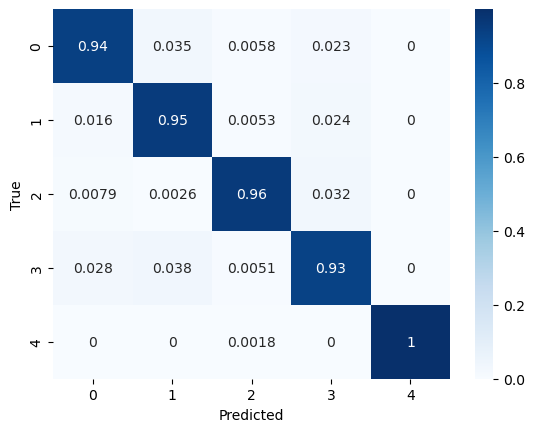

"\nfpr, tpr, thresholds = roc_curve(label_list, pred_list) \n\nplt.plot(fpr, tpr)\n\nplt.xlabel('FP Rate')\nplt.ylabel('TP Rate')\n\nplt.show()\n\nprint(roc_auc_score(label_list, pred_list))\n"

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label_list, pred_list, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
'''
fpr, tpr, thresholds = roc_curve(label_list, pred_list) 

plt.plot(fpr, tpr)

plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.show()

print(roc_auc_score(label_list, pred_list))
'''

In [61]:
#class_list = ['협박 대화', '갈취 대화',  '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']  
cm

array([[324,  12,   2,   8,   0],
       [  6, 360,   2,   9,   0],
       [  3,   1, 363,  12,   0],
       [ 11,  15,   2, 365,   0],
       [  0,   0,   1,   0, 559]])

## Test

In [36]:
test_dataset = CleanTalkDataset(test_df['conversation'],None, False,None, tokenizer)

test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)

for text, label in test_dataset:
    print(text['input_ids'].size())
    print(text['attention_mask'].size())

    break

torch.Size([1, 250])
torch.Size([1, 250])


## 저장한 모델 불러오기

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("general_aug_rt_kr_electra_model.pt", map_location=device, weights_only=False)
model.to(device)
model.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [38]:
model.eval()
predict_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for test_input, _ in test_dataloader:
        attention_mask = test_input['attention_mask'].squeeze(1).to(device)
        input_ids = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_ids, attention_mask) # from the forward function
        preds = output[0].argmax(dim=-1)
        predict_list.append(preds)
        
predict_list = torch.cat(predict_list).cpu().detach().numpy()

## Submission 파일 생성

In [39]:
submission_df['class'] = predict_list
submission_df

,idx,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,3


In [40]:
submission_df.to_csv("../data/0212_1_general_aug_rt_kr_electra_model_submission.csv", index=False)

### GPU 메모리 정리

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()